# Hospital Inpatient Discharges and Cost Prediction

This notebook focuses on analyzing hospital inpatient discharge data and associated costs to predict key metrics for the next year. Specifically, we aim to forecast:

- **Discharges**: The number of patients discharged.
- **Median Costs**: The median cost associated with the discharges.
- **Median Charges**: The median charges associated with the discharges.

The analysis is conducted for a specific hospital and Diagnosis-Related Group (DRG) type, leveraging historical data to build predictive models. By understanding trends and patterns in the data, we aim to provide actionable insights for healthcare planning and resource allocation.

### Imports

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import shapiro, normaltest
import pmdarima as pm # pm.auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Data Ingestion, Cleaning, and EDA

In [2]:
data = pd.read_csv('../data/raw/Hospital_Inpatient_Discharges__SPARCS_De-Identified___Cost_Transparency__Beginning_2009_20250426.csv')

In [3]:
data.head()

,Year,Facility Id,Facility Name,APR DRG Code,APR Severity of Illness Code,APR DRG Description,APR Severity of Illness Description,APR Medical Surgical Code,APR Medical Surgical Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost
0,2016,4,Albany Memorial Hospital,194,1,Heart Failure,Minor,M,Medical,2,"8,375.41","8,375.41","3,585.05","3,585.05"
1,2016,4,Albany Memorial Hospital,194,2,Heart Failure,Moderate,M,Medical,40,"14,029.82","12,176.95","6,182.67","5,253.15"
2,2016,4,Albany Memorial Hospital,194,3,Heart Failure,Major,M,Medical,70,"23,921.77","20,229.81","11,149.49","9,068.10"
3,2016,4,Albany Memorial Hospital,194,4,Heart Failure,Extreme,M,Medical,12,"51,260.45","35,210.82","26,081.70","15,230.62"
4,2016,4,Albany Memorial Hospital,196,4,Cardiac Arrest,Extreme,M,Medical,1,"25,357.84","25,357.84","7,791.75","7,791.75"


In [20]:
year_counts = data['Year'].value_counts()
print(year_counts)

Year
2009    129255
2010    128014
2011    126288
2012    123600
2013    117226
2016    114602
2015    114581
2014    114376
2017    113730
2021    111155
Name: count, dtype: int64


In [17]:
facility_id_counts = data['Facility Name'].value_counts()
print(facility_id_counts[:30])  # Display the top 10 facility IDs and their counts

Facility Name
Strong Memorial Hospital                                                11162
Mount Sinai Hospital                                                    11149
Albany Medical Center Hospital                                          10925
Westchester Medical Center                                              10642
North Shore University Hospital                                         10612
Montefiore Medical Center - Henry & Lucy Moses Div                      10223
New York Presbyterian Hospital - Columbia Presbyterian Center           10125
Maimonides Medical Center                                               10081
New York Presbyterian Hospital - New York Weill Cornell Center          10027
Bellevue Hospital Center                                                 9966
Staten Island University Hosp-North                                      9964
Rochester General Hospital                                               9796
Lenox Hill Hospital                               

In [19]:
westchester_data = data[data['Facility Id'] == 1139]
year_counts_westchester = westchester_data['Year'].value_counts()
print(year_counts_westchester)

Year
2021    1102
2009    1073
2012    1072
2010    1071
2011    1066
2017    1066
2013    1053
2015    1051
2014    1051
2016    1037
Name: count, dtype: int64


In [ ]:
filtered_data = data[data['Facility Id'] == 925]
filtered_data

,Year,Facility Id,Facility Name,APR DRG Code,APR Severity of Illness Code,APR DRG Description,APR Severity of Illness Description,APR Medical Surgical Code,APR Medical Surgical Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost
24770,2016,925,Good Samaritan Hospital Medical Center,4,3,Tracheostomy W MV 96+ Hours W Extensive Proced...,Major,P,Surgical,2,"576,038.56","576,038.56","142,543.88","142,543.88"
24771,2016,925,Good Samaritan Hospital Medical Center,4,4,Tracheostomy W MV 96+ Hours W Extensive Proced...,Extreme,P,Surgical,51,"876,133.60","831,101.76","265,617.24","232,645.06"
24772,2016,925,Good Samaritan Hospital Medical Center,5,3,Tracheostomy W MV 96+ Hours W/O Extensive Proc...,Major,P,Surgical,4,"404,711.46","298,702.45","124,266.02","98,492.40"
24773,2016,925,Good Samaritan Hospital Medical Center,5,4,Tracheostomy W MV 96+ Hours W/O Extensive Proc...,Extreme,P,Surgical,31,"549,799.45","548,915.51","166,810.56","162,843.87"
24774,2016,925,Good Samaritan Hospital Medical Center,20,1,Craniotomy For Trauma,Minor,P,Surgical,9,"125,171.39","130,588.80","39,308.86","42,160.40"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139446,2021,925,Good Samaritan Hospital Medical Center,952,2,NON-EXTENSIVE O.R. PROCEDURE UNRELATED TO PRIN...,Moderate,P,Surgical,9,"89,017.53","90,487.19","18,326.71","18,625.98"
1139447,2021,925,Good Samaritan Hospital Medical Center,952,3,NON-EXTENSIVE O.R. PROCEDURE UNRELATED TO PRIN...,Major,P,Surgical,6,"144,513.73","115,018.44","26,301.73","19,523.85"
1139448,2021,925,Good Samaritan Hospital Medical Center,952,4,NON-EXTENSIVE O.R. PROCEDURE UNRELATED TO PRIN...,Extreme,P,Surgical,1,"275,863.65","275,863.65","50,465.72","50,465.72"
1139449,2021,925,Good Samaritan Hospital Medical Center,955,0,PRINCIPAL DIAGNOSIS INVALID AS DISCHARGE DIAGN...,Not Applicable,NaN,Other,1,"11,211.00","11,211.00","3,349.20","3,349.20"


In [5]:
apr_drg_code_counts = filtered_data['APR DRG Code'].value_counts()
print(apr_drg_code_counts)

APR DRG Code
135    40
143    40
174    40
171    40
282    40
       ..
178     2
863     2
580     1
160     1
27      1
Name: count, Length: 338, dtype: int64


In [6]:
filtered_apr_drg_135 = filtered_data[filtered_data['APR DRG Code'] == 135]
filtered_apr_drg_135

,Year,Facility Id,Facility Name,APR DRG Code,APR Severity of Illness Code,APR DRG Description,APR Severity of Illness Description,APR Medical Surgical Code,APR Medical Surgical Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost
24927,2016,925,Good Samaritan Hospital Medical Center,135,1,Major Chest & Respiratory Trauma,Minor,M,Medical,38,"32,388.20","28,304.00","5,543.86","4,155.20"
24928,2016,925,Good Samaritan Hospital Medical Center,135,2,Major Chest & Respiratory Trauma,Moderate,M,Medical,20,"35,410.10","36,981.00","5,813.96","5,548.96"
24929,2016,925,Good Samaritan Hospital Medical Center,135,3,Major Chest & Respiratory Trauma,Major,M,Medical,23,"69,727.91","53,276.00","16,653.52","9,625.59"
24930,2016,925,Good Samaritan Hospital Medical Center,135,4,Major Chest & Respiratory Trauma,Extreme,M,Medical,4,"138,680.57","167,126.00","34,629.13","35,871.59"
139886,2015,925,Good Samaritan Hospital Medical Center,135,1,Major Chest & Respiratory Trauma,Minor,M,Medical,28,"31,559.64","31,372.00","5,210.96","4,739.27"
139887,2015,925,Good Samaritan Hospital Medical Center,135,2,Major Chest & Respiratory Trauma,Moderate,M,Medical,21,"39,987.81","33,379.00","7,077.38","5,958.59"
139888,2015,925,Good Samaritan Hospital Medical Center,135,3,Major Chest & Respiratory Trauma,Major,M,Medical,18,"67,181.17","57,245.50","14,692.92","9,088.38"
139889,2015,925,Good Samaritan Hospital Medical Center,135,4,Major Chest & Respiratory Trauma,Extreme,M,Medical,1,"49,073.00","49,073.00","14,127.68","14,127.68"
254916,2014,925,Good Samaritan Hospital Medical Center,135,1,Major Chest & Respiratory Trauma,Minor,M,Medical,24,"36,279.38","31,738.50","6,148.15","4,422.46"
254917,2014,925,Good Samaritan Hospital Medical Center,135,2,Major Chest & Respiratory Trauma,Moderate,M,Medical,26,"45,986.46","41,330.50","9,375.53","6,515.46"


In [8]:
filtered_apr_drg_135.shape

(40, 14)

In [11]:
year_counts = filtered_apr_drg_135['Year'].value_counts()
print(year_counts)

Year
2016    4
2015    4
2014    4
2013    4
2012    4
2011    4
2010    4
2009    4
2017    4
2021    4
Name: count, dtype: int64


## Key Note: Missing Data in the Dataset

The dataset does not contain data for the years 2018–2020 and 2022 onward. This gap in data must be addressed to ensure accurate analysis and forecasting.

## Selected Hospital and DRG Type
The hospital and DRG code we selected are as follows:

### Hospital:
- **Good Samaritan Hospital Medical Center**: This hospital was chosen based on its Facility ID (`925`) and its relevance to the analysis. It provides a focused dataset for examining specific Diagnosis-Related Groups (DRGs) and their associated metrics.

### DRG Code:
- **APR DRG Code 135**: This code corresponds to **"Major Chest & Respiratory Trauma"**. It was selected because:
    - It represents a critical medical condition that requires significant hospital resources.
    - The dataset contains sufficient records for this DRG, allowing for meaningful analysis and forecasting.
    - It provides an opportunity to study trends in discharges, costs, and charges for a specific, impactful medical condition.

By focusing on this hospital and DRG code, we aim to analyze trends and predict key metrics (e.g., discharges, median costs) for better healthcare planning and resource allocation.

In [31]:
good_samaritan_df = filtered_apr_drg_135.drop(columns=[
    'Facility Id',
    'Facility Name',
    'APR DRG Code',
    'APR Severity of Illness Code',
    'APR DRG Description',
    'APR Medical Surgical Code',
    'APR Medical Surgical Description'
])
good_samaritan_df

,Year,APR Severity of Illness Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost
24927,2016,Minor,38,"32,388.20","28,304.00","5,543.86","4,155.20"
24928,2016,Moderate,20,"35,410.10","36,981.00","5,813.96","5,548.96"
24929,2016,Major,23,"69,727.91","53,276.00","16,653.52","9,625.59"
24930,2016,Extreme,4,"138,680.57","167,126.00","34,629.13","35,871.59"
139886,2015,Minor,28,"31,559.64","31,372.00","5,210.96","4,739.27"
139887,2015,Moderate,21,"39,987.81","33,379.00","7,077.38","5,958.59"
139888,2015,Major,18,"67,181.17","57,245.50","14,692.92","9,088.38"
139889,2015,Extreme,1,"49,073.00","49,073.00","14,127.68","14,127.68"
254916,2014,Minor,24,"36,279.38","31,738.50","6,148.15","4,422.46"
254917,2014,Moderate,26,"45,986.46","41,330.50","9,375.53","6,515.46"


In [32]:
good_samaritan_df = good_samaritan_df.sort_values(by='Year').reset_index(drop=True)
good_samaritan_df

,Year,APR Severity of Illness Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost
0,2009,Extreme,4,"219,737.00","180,978.00","47,366.00","41,622.00"
1,2009,Major,16,"46,111.00","44,247.00","8,709.00","7,898.00"
2,2009,Moderate,18,"29,193.00","25,966.00","4,943.00","3,811.00"
3,2009,Minor,24,"22,147.00","19,317.00","3,621.00","3,216.00"
4,2010,Extreme,6,"47,055.00","48,917.00","10,361.00","9,453.00"
5,2010,Moderate,25,"27,651.00","27,237.00","4,706.00","4,308.00"
6,2010,Minor,20,"24,124.00","23,138.00","4,026.00","3,936.00"
7,2010,Major,14,"47,807.00","42,958.00","8,369.00","7,142.00"
8,2011,Extreme,1,"44,685.16","44,685.16","8,925.09","8,925.09"
9,2011,Major,18,"44,845.23","41,520.40","7,969.57","6,609.89"


In [33]:
# Convert columns to numeric, removing commas and handling errors
good_samaritan_df['Discharges'] = pd.to_numeric(good_samaritan_df['Discharges'].str.replace(',', ''), errors='coerce')
good_samaritan_df['Mean Charge'] = pd.to_numeric(good_samaritan_df['Mean Charge'].str.replace(',', ''), errors='coerce')
good_samaritan_df['Median Charge'] = pd.to_numeric(good_samaritan_df['Median Charge'].str.replace(',', ''), errors='coerce')
good_samaritan_df['Mean Cost'] = pd.to_numeric(good_samaritan_df['Mean Cost'].str.replace(',', ''), errors='coerce')
good_samaritan_df['Median Cost'] = pd.to_numeric(good_samaritan_df['Median Cost'].str.replace(',', ''), errors='coerce')

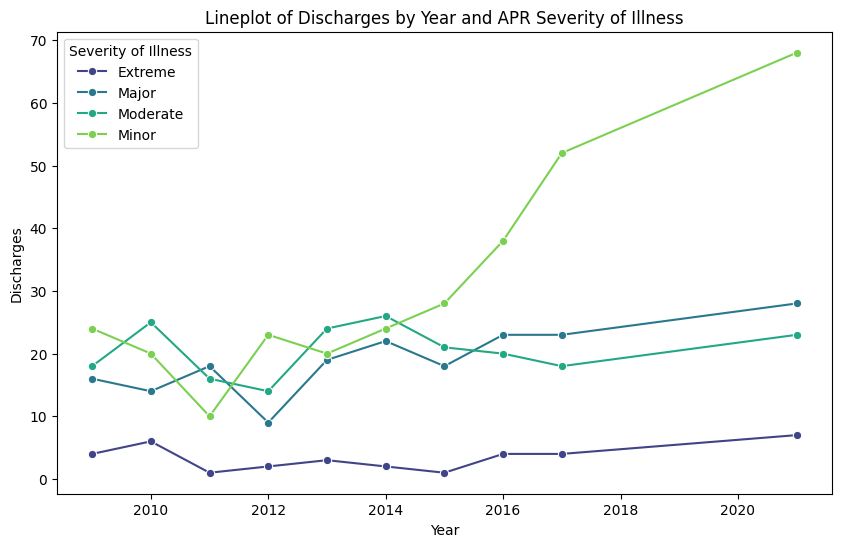

In [35]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=good_samaritan_df,
    x='Year',
    y='Discharges',
    hue='APR Severity of Illness Description',
    palette='viridis',
    marker='o'
)
plt.title('Lineplot of Discharges by Year and APR Severity of Illness')
plt.xlabel('Year')
plt.ylabel('Discharges')
plt.legend(title='Severity of Illness')
plt.show()

## Visualizations

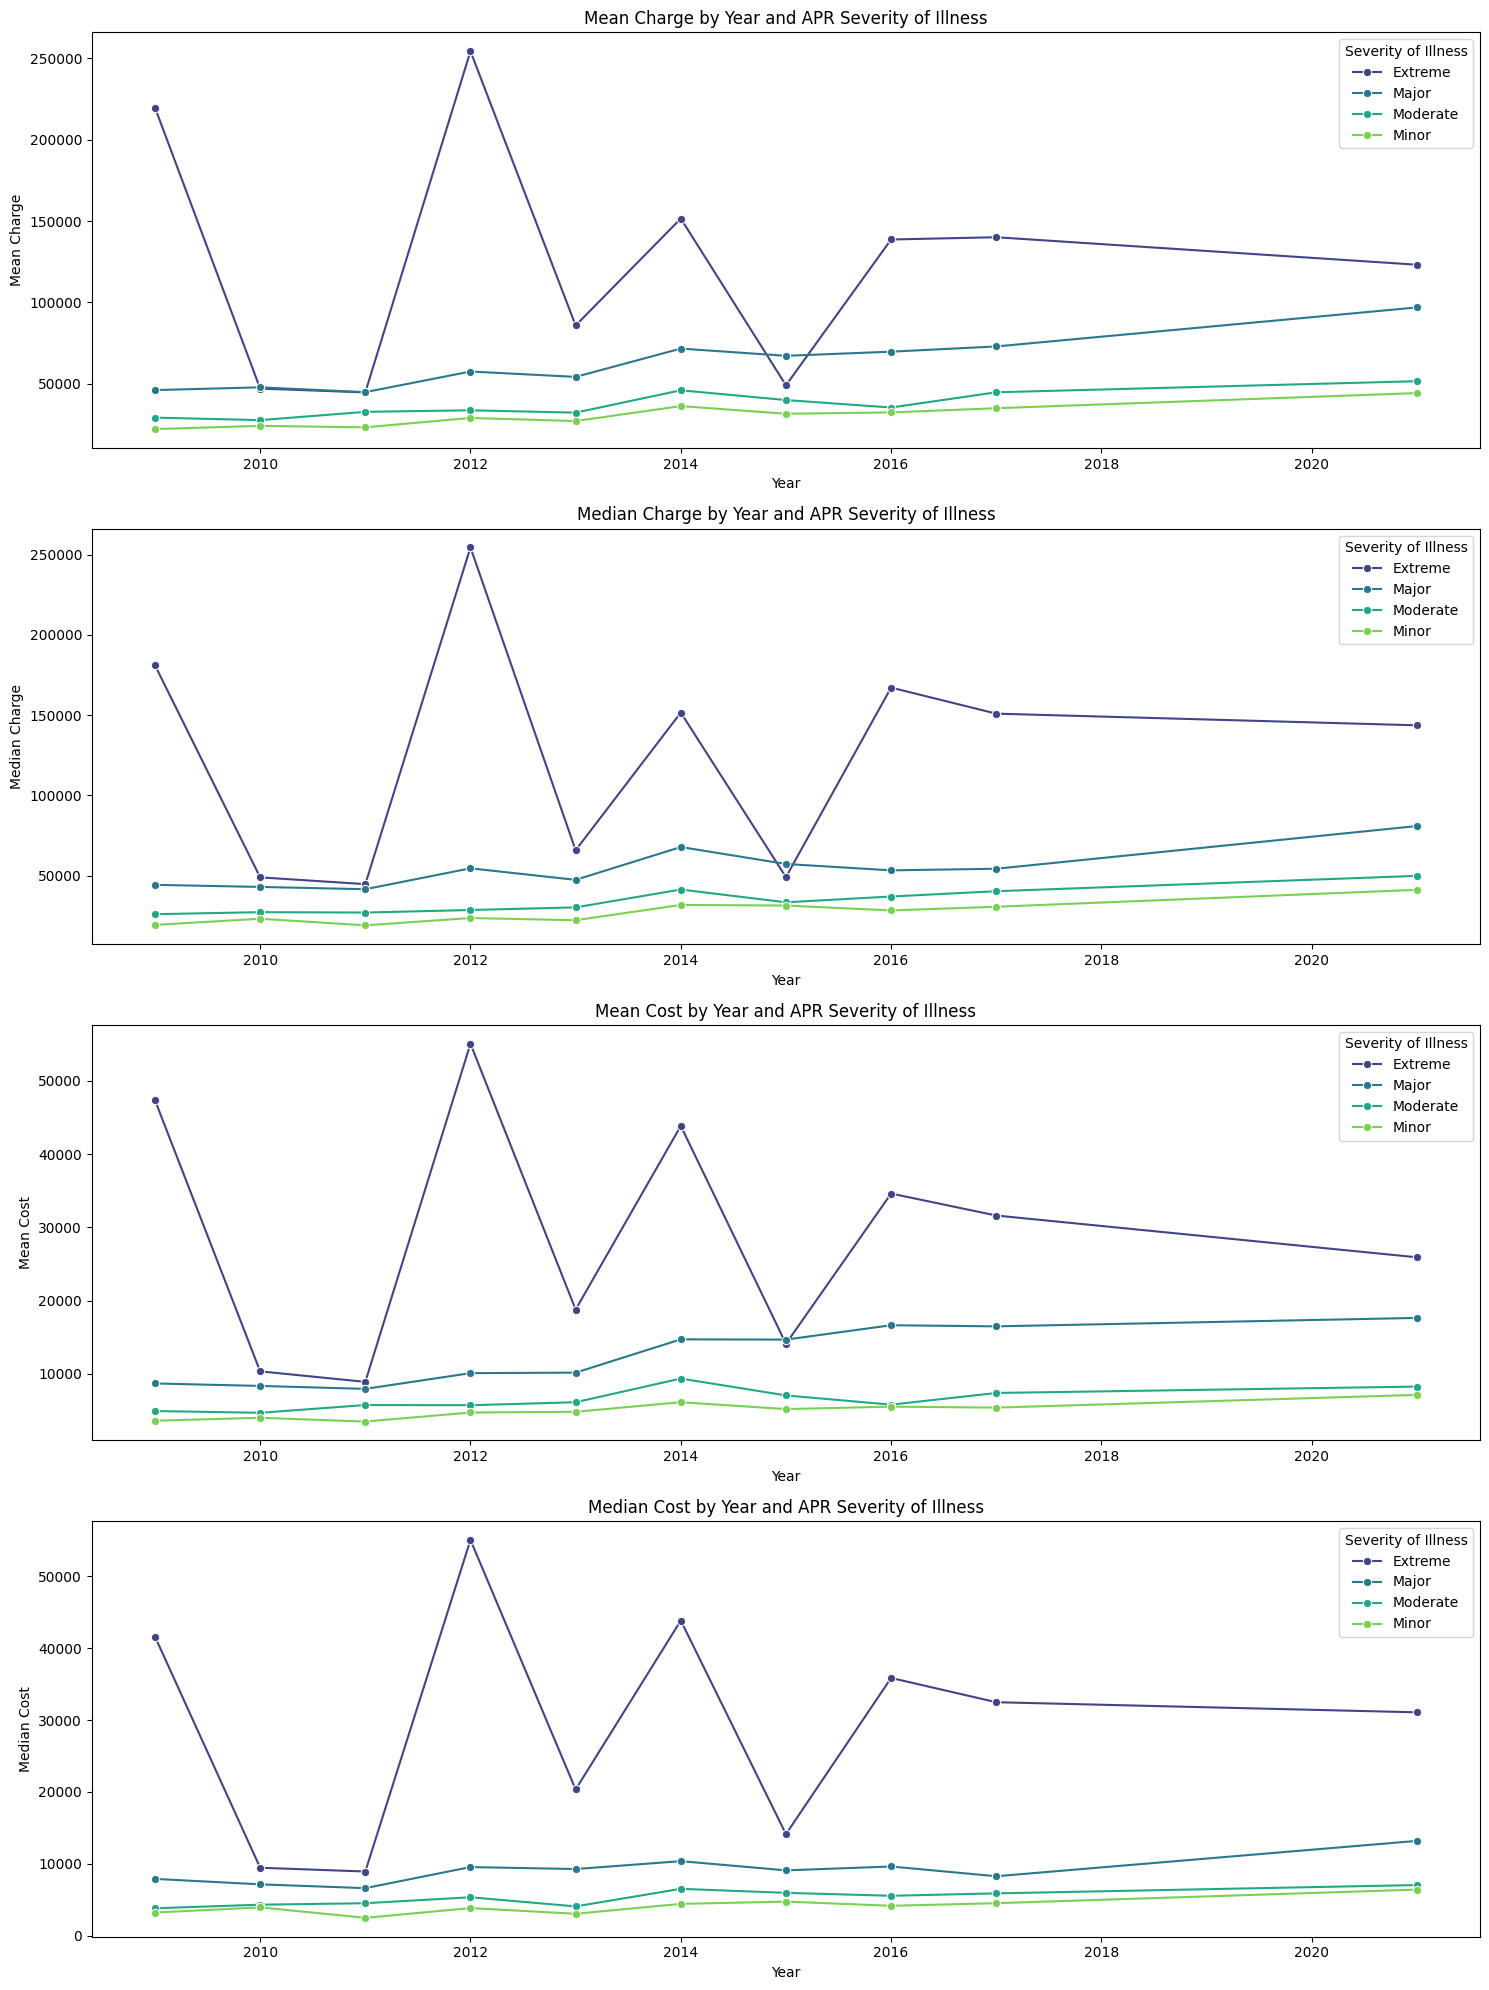

In [36]:
metrics = ['Mean Charge', 'Median Charge', 'Mean Cost', 'Median Cost']
titles = ['Mean Charge by Year and APR Severity of Illness',
          'Median Charge by Year and APR Severity of Illness',
          'Mean Cost by Year and APR Severity of Illness',
          'Median Cost by Year and APR Severity of Illness']

plt.figure(figsize=(15, 20))
for i, metric in enumerate(metrics):
    plt.subplot(4, 1, i + 1)
    sns.lineplot(
        data=good_samaritan_df,
        x='Year',
        y=metric,
        hue='APR Severity of Illness Description',
        palette='viridis',
        marker='o'
    )
    plt.title(titles[i])
    plt.xlabel('Year')
    plt.ylabel(metric)
    plt.legend(title='Severity of Illness')
    plt.tight_layout()

plt.show()

In [37]:
# Perform aggregation
aggregated_data = good_samaritan_df.groupby('Year').agg({
  'Discharges': 'sum',
  'Mean Charge': 'mean',
  'Median Charge': 'mean',
  'Mean Cost': 'mean',
  'Median Cost': 'mean'
}).reset_index()

print(aggregated_data)

   Year  Discharges  Mean Charge  Median Charge   Mean Cost  Median Cost
0  2009          62   79297.0000     67627.0000  16159.7500   14136.7500
1  2010          65   36659.2500     35562.5000   6865.5000    6209.7500
2  2011          45   36375.3700     33057.7650   6540.5150    5632.1250
3  2012          48   93652.7050     90278.3750  18918.7550   18450.8075
4  2013          66   49849.9500     41394.1250   9992.0350    9184.5750
5  2014          74   76362.5900     73108.8775  18527.9450   16292.2275
6  2015          68   46950.4050     42767.3750  10277.2350    8478.4800
7  2016          85   69051.6950     71421.7500  15660.1175   13800.3350
8  2017          97   73188.3025     69016.1250  15238.3500   12791.2150
9  2021         126   78993.1300     78872.8975  14752.9900   14433.5975


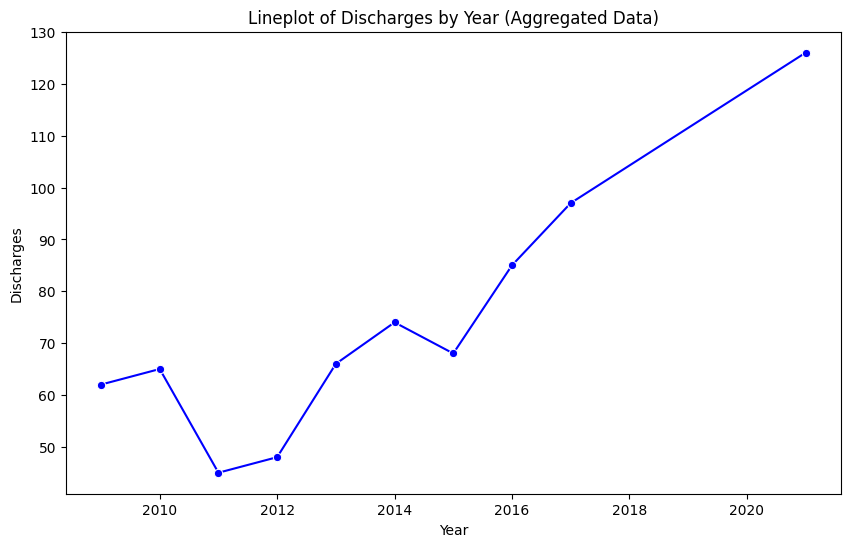

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=aggregated_data,
    x='Year',
    y='Discharges',
    marker='o',
    color='blue'
)
plt.title('Lineplot of Discharges by Year (Aggregated Data)')
plt.xlabel('Year')
plt.ylabel('Discharges')
plt.show()

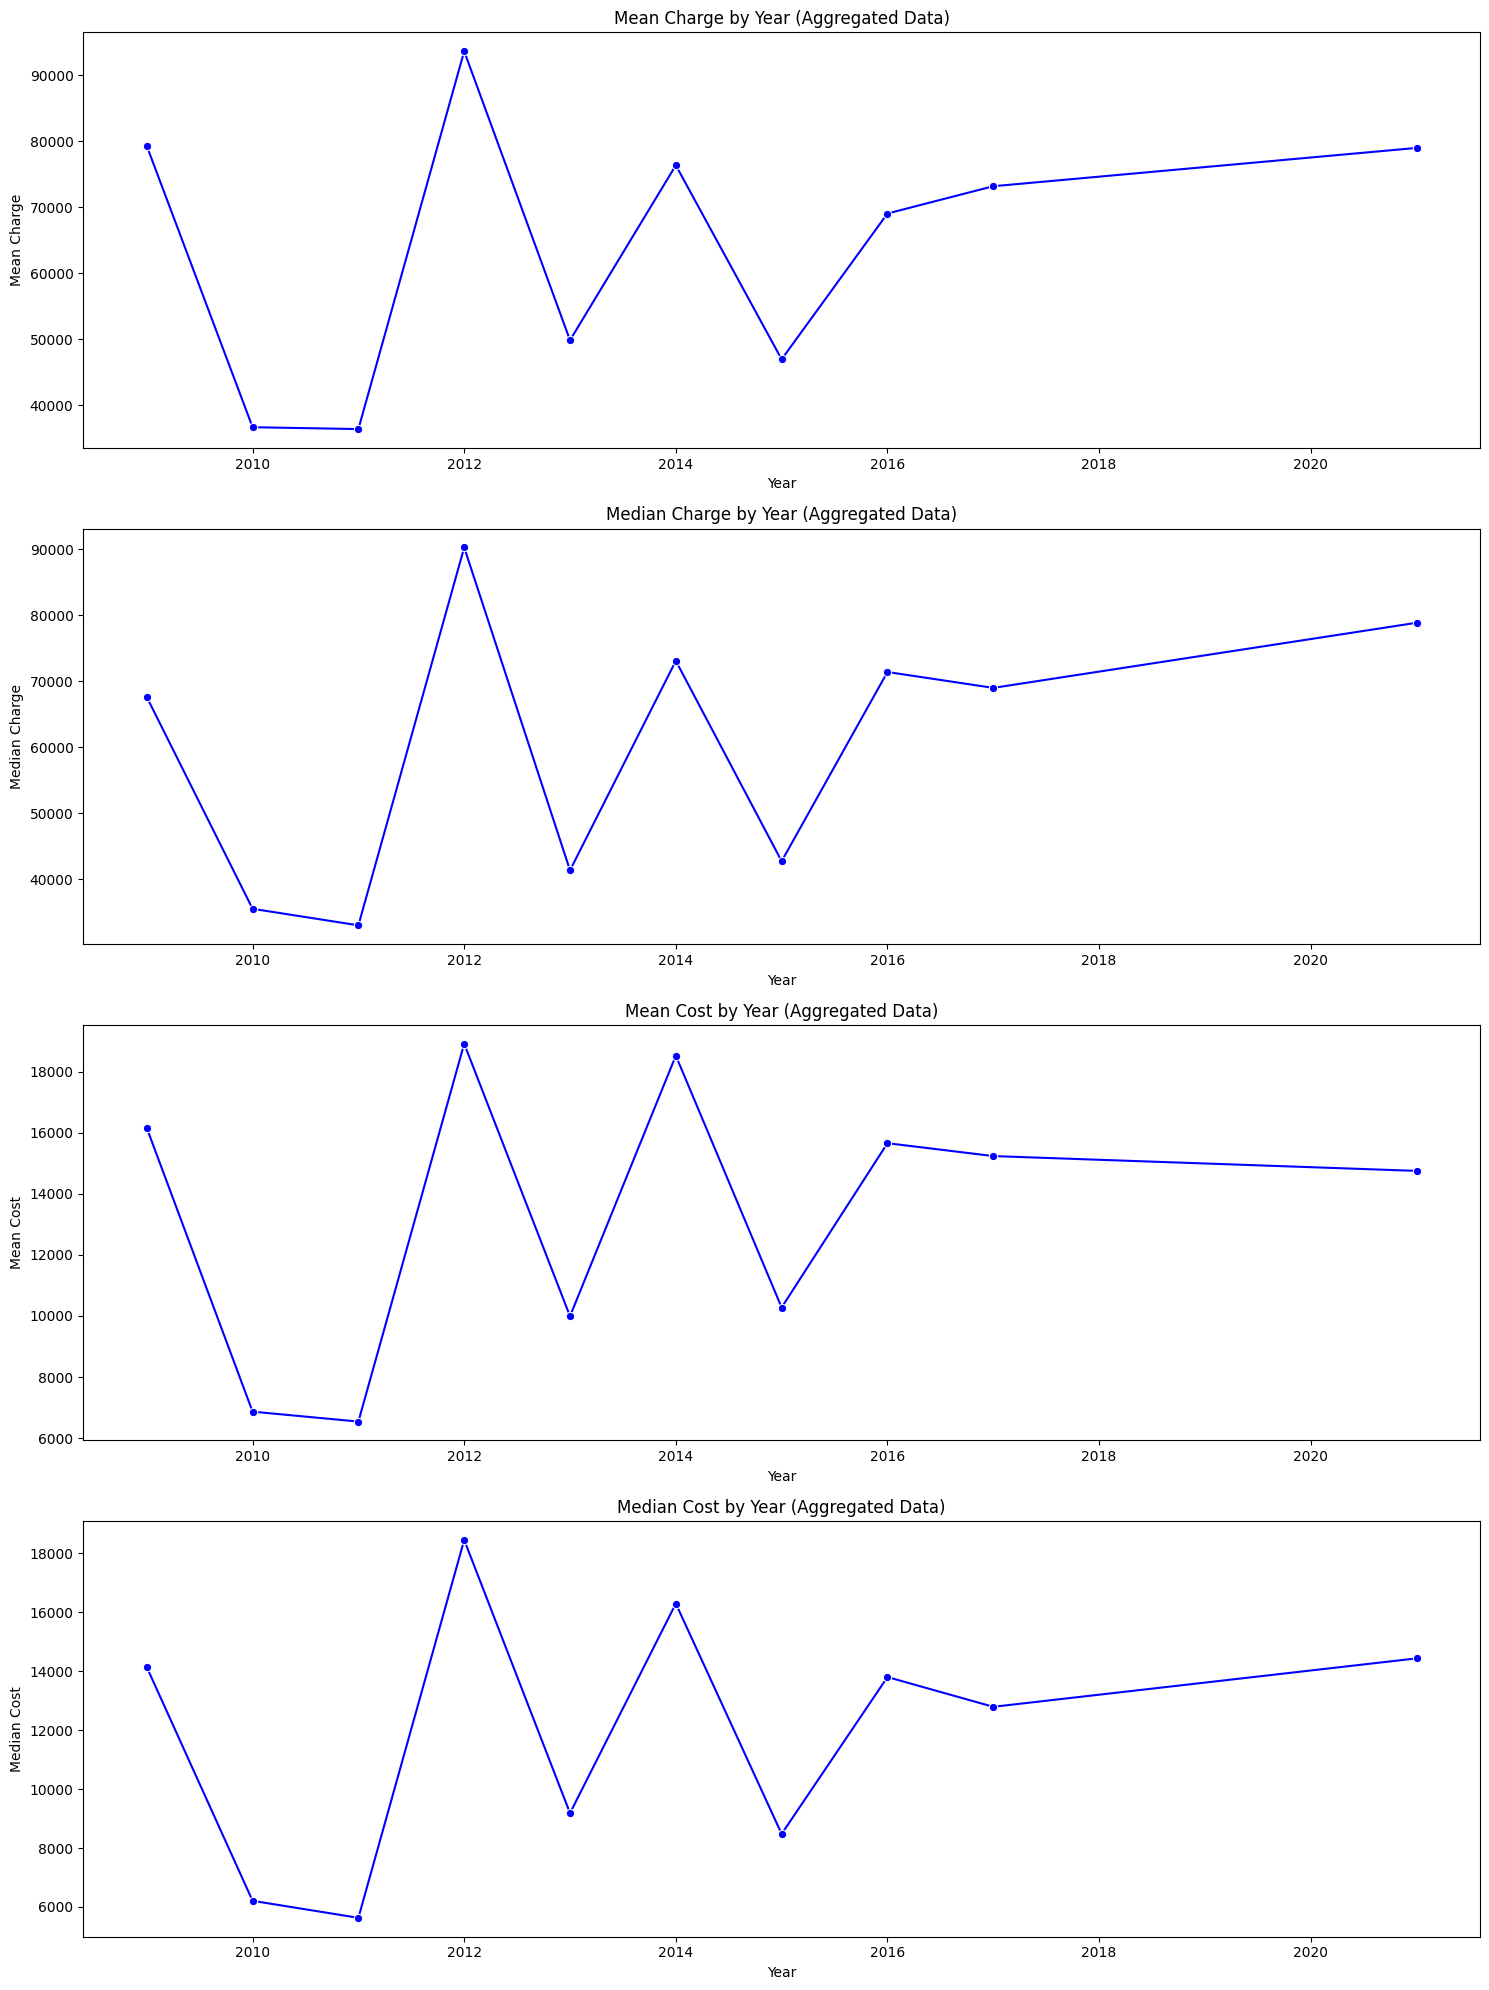

In [39]:
metrics = ['Mean Charge', 'Median Charge', 'Mean Cost', 'Median Cost']
titles = ['Mean Charge by Year (Aggregated Data)',
          'Median Charge by Year (Aggregated Data)',
          'Mean Cost by Year (Aggregated Data)',
          'Median Cost by Year (Aggregated Data)']

plt.figure(figsize=(15, 20))
for i, metric in enumerate(metrics):
    plt.subplot(4, 1, i + 1)
    sns.lineplot(
        data=aggregated_data,
        x='Year',
        y=metric,
        marker='o',
        color='blue'
    )
    plt.title(titles[i])
    plt.xlabel('Year')
    plt.ylabel(metric)
    plt.tight_layout()

plt.show()


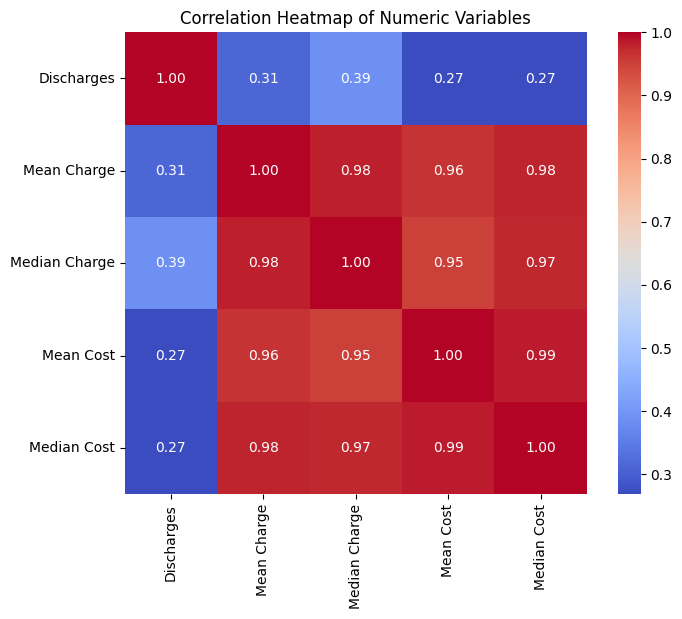

In [40]:
# Compute the correlation matrix for numeric variables excluding 'Year'
correlation_matrix = aggregated_data.drop(columns=['Year']).corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

### Charge/Cost Variables and Correlation Analysis

The charge and cost variables are understandably highly positively correlated with each other. For predicting discharges for the year 2022, it is important to note:

- Cost/charge variables should not be used as exogenous variables due to lack of moderately strong correlation.
- Discharges should be treated as a pure univariate time-series for prediction.

In [41]:
discharges_df = aggregated_data[['Year', 'Discharges']]
print(discharges_df)

   Year  Discharges
0  2009          62
1  2010          65
2  2011          45
3  2012          48
4  2013          66
5  2014          74
6  2015          68
7  2016          85
8  2017          97
9  2021         126


## Overview of Models Our Team Considered

| Model | Description | Strengths for This Task | Weaknesses for This Task | Reasons for Using |
|:---|:---|:---|:---|:---|
| **ARIMA** | Captures trend and autocorrelation, no explicit seasonality | Simple, effective for small yearly datasets, low risk of overfitting | Cannot explicitly model repeating seasonal patterns (not critical here) | Best starting point for yearly hospital forecasting |
| **SARIMA** | Extension of ARIMA with seasonal components (captures seasonality trends like yearly cycles) | Useful if strong seasonal patterns exist and more data points (monthly/quarterly) | Overcomplicated for small yearly datasets; risk of overfitting | Not ideal — seasonality not meaningful with limited yearly data |
| **Prophet** | Decomposes time series into trend, seasonality, holidays automatically; robust to missing data | Handles irregular time series easily, good at capturing complex patterns | Requires more data to meaningfully fit trend/seasonality; heavier and can overfit | Overkill for small yearly datasets with no known seasonal effects |

---

Since the available dataset consists of only 9 yearly observations (2009–2017 and 2021) and there is no strong evidence of seasonal effects at the yearly level, we believe that starting with a **simple ARIMA model** is ultimately the best approach.
This is because it balances model complexity and forecasting accuracy, and avoids unnecessary assumptions about seasonality that are not clearly supported by the data.


In [44]:
# Prepare the data
discharges_series = discharges_df.set_index('Year')['Discharges']
discharges_series

Year
2009     62
2010     65
2011     45
2012     48
2013     66
2014     74
2015     68
2016     85
2017     97
2021    126
Name: Discharges, dtype: int64

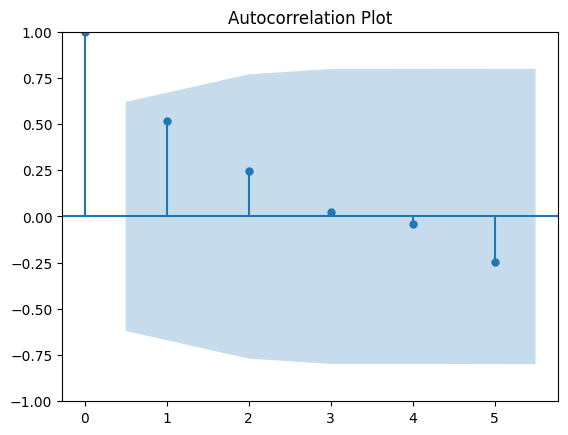

In [46]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(discharges_series)
plt.title('Autocorrelation Plot')
plt.show()

### ACF Interpretations
- The ACF plot shows a significant positive autocorrelation at lag 1 (~0.5), indicating that the discharges in one year are moderately influenced by the previous year's discharges.
- At lag 2, the autocorrelation decreases (~0.25) but remains positive, suggesting a weaker influence from two years prior.
- Beyond lag 2, the autocorrelations fall within the confidence interval, implying no statistically significant correlation at higher lags.
- There is no evidence of seasonality, as there are no repeating significant peaks at regular intervals.
- The gradual decline in autocorrelation suggests the presence of a trend in the data.

In [48]:
# Auto_arima to find the best ARIMA model
arima_model = pm.auto_arima(
    discharges_series,
    seasonal=False,  # Set to False as determined by our non-seasonal data
    trace=True,      # Prints the progress of model selection
    error_action='ignore',  # Ignores errors and continues
    suppress_warnings=True, # Suppresses warnings
    stepwise=True     # Uses a stepwise approach for faster computation
)

# Print the summary of the selected model
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=94.846, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=117.267, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=90.637, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=92.038, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=92.068, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=94.034, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=89.716, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=94.906, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=90.892, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=91.107, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=92.740, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.997 seconds
                               SARIMAX Results       

In [54]:
# Forecast for 2022
forecast_2022 = arima_model.predict(n_periods=1)
print(f"Predicted discharges for 2022: {forecast_2022[10]}")

Predicted discharges for 2022: 119.74336436737863


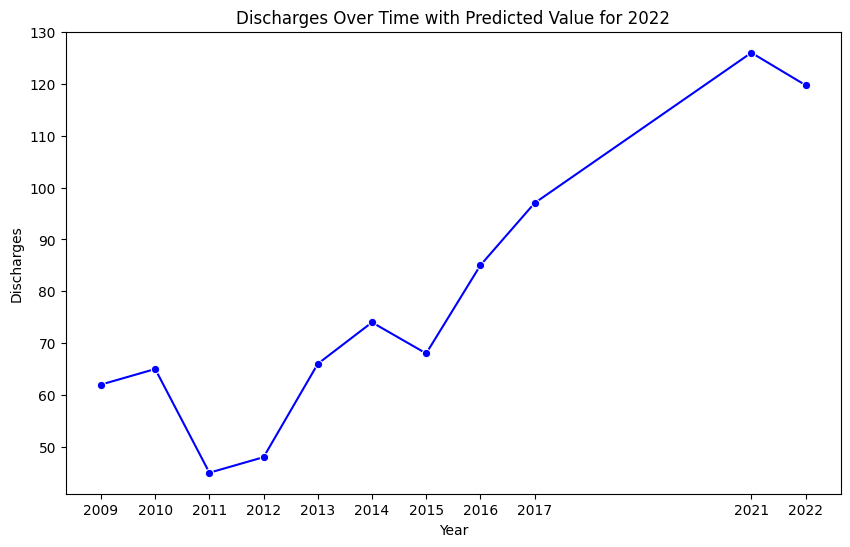

In [57]:
# Append the predicted discharges for 2022 to the series using pd.concat
extended_discharges_series = pd.concat([discharges_series, pd.Series({2022: forecast_2022.iloc[0]})])

# Plot the extended series
plt.figure(figsize=(10, 6))
sns.lineplot(data=extended_discharges_series, marker='o', color='blue')
plt.title('Discharges Over Time with Predicted Value for 2022')
plt.xlabel('Year')
plt.ylabel('Discharges')
plt.xticks(extended_discharges_series.index)  # Ensure all years are shown on the x-axis
plt.show()

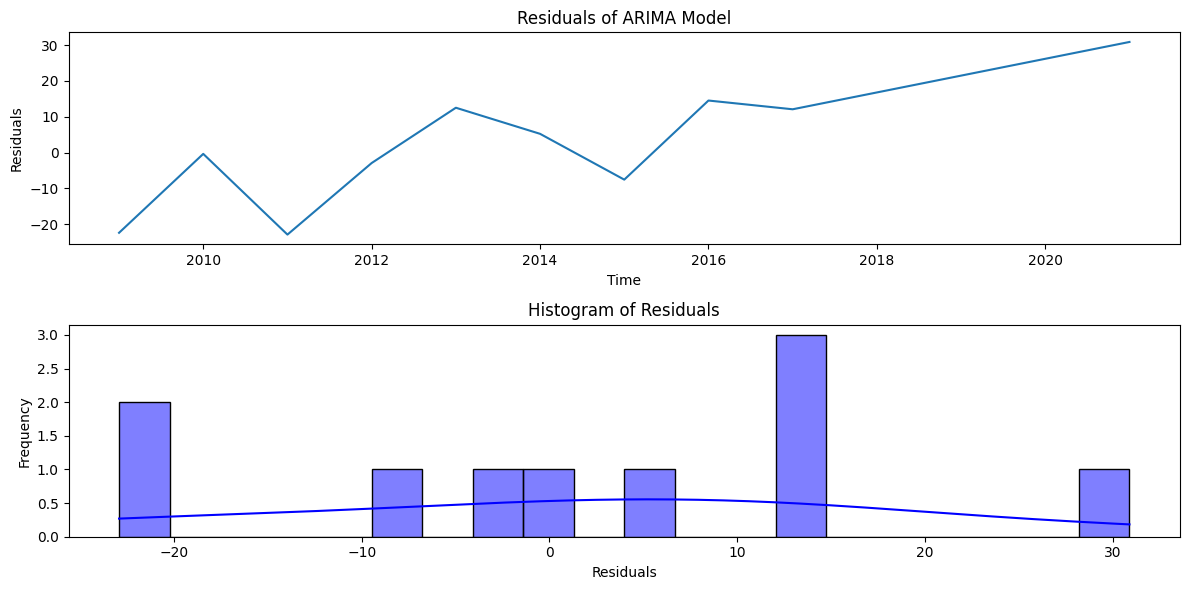

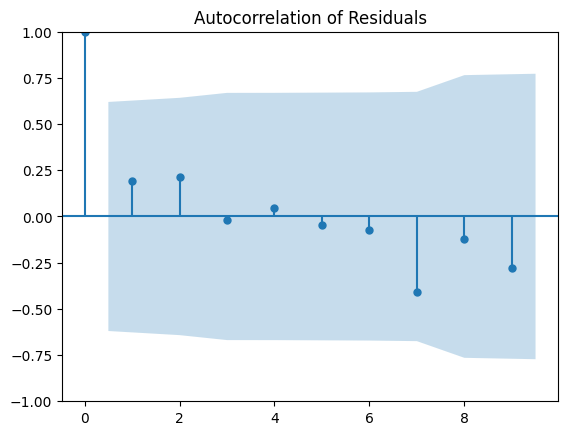

Shapiro-Wilk Test: Statistic=0.9558704085182617, p-value=0.7379565673749234
D'Agostino's K-squared Test: Statistic=0.009483379163062812, p-value=0.9952695344811643


In [ ]:
# Extract residuals from the ARIMA model
residuals = arima_model.resid()

# Plot residuals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(2, 1, 2)
sns.histplot(residuals, kde=True, bins=20, color='blue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Dynamically set the maximum lags based on the length of residuals
max_lags = min(20, len(residuals) - 1)  # Ensure lags do not exceed the number of residuals

# Plot autocorrelation of residuals
plot_acf(residuals, lags=max_lags)
plt.title('Autocorrelation of Residuals')
plt.show()

# Perform statistical tests
shapiro_test = shapiro(residuals)
dagostino_test = normaltest(residuals)

print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
print(f"D'Agostino's K-squared Test: Statistic={dagostino_test.statistic}, p-value={dagostino_test.pvalue}")

Shapiro-Wilk Test:

- Statistic: 0.9559
- p-value: 0.738
- Interpretation: The p-value is greater than 0.05, indicating that the residuals are not significantly different from a normal distribution. This suggests that the residuals are approximately normally distributed.

D'Agostino's K-squared Test:

- Statistic: 0.0095
- p-value: 0.995
- Interpretation: The p-value is much greater than 0.05, further confirming that the residuals are not significantly different from a normal distribution.

Conclusion:
- Both tests indicate that the residuals are approximately normally distributed, which is a good sign for the validity of our ARIMA model.

In [61]:
median_cost_series = aggregated_data.set_index('Year')['Median Cost']
print(median_cost_series)

Year
2009    14136.7500
2010     6209.7500
2011     5632.1250
2012    18450.8075
2013     9184.5750
2014    16292.2275
2015     8478.4800
2016    13800.3350
2017    12791.2150
2021    14433.5975
Name: Median Cost, dtype: float64


In [63]:
# Auto_arima to find the best ARIMA model for median_cost_series
median_cost_arima_model = pm.auto_arima(
    median_cost_series,
    seasonal=False,  # Set to False as we are not considering seasonality
    trace=True,      # Prints the progress of model selection
    error_action='ignore',  # Ignores errors and continues
    suppress_warnings=True, # Suppresses warnings
    stepwise=True     # Uses a stepwise approach for faster computation
)

# Print the summary of the selected model
print(median_cost_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=10582.548, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=219.252, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=210.452, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=218.198, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=207.658, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=201.154, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=199.222, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=198.793, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=198.857, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.

In [64]:
# Forecast for 2022
median_cost_forecast_2022 = median_cost_arima_model.predict(n_periods=1)
print(f"Predicted Median Cost for 2022: {median_cost_forecast_2022[10]}")

Predicted Median Cost for 2022: 11940.986249999998


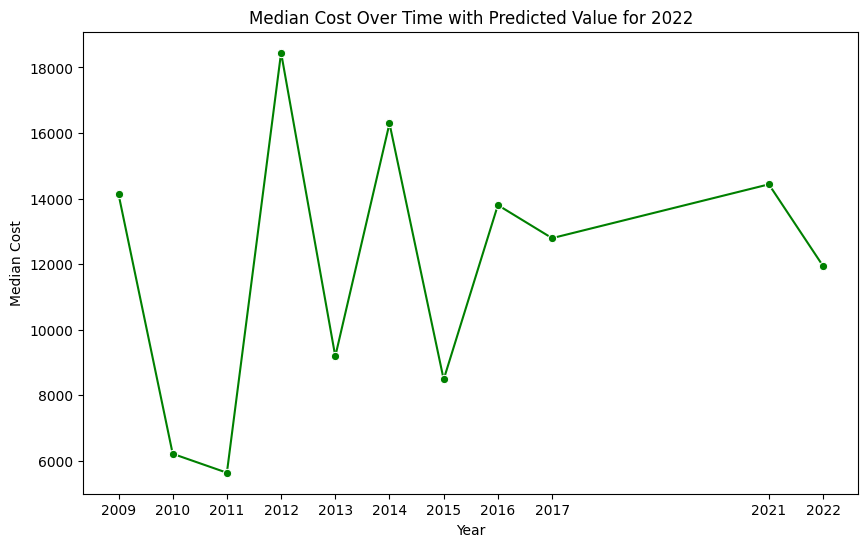

In [65]:
# Extend the median cost series with the 2022 forecast
extended_median_cost_series = pd.concat([median_cost_series, pd.Series({2022: median_cost_forecast_2022.iloc[0]})])

# Plot the extended series
plt.figure(figsize=(10, 6))
sns.lineplot(data=extended_median_cost_series, marker='o', color='green')
plt.title('Median Cost Over Time with Predicted Value for 2022')
plt.xlabel('Year')
plt.ylabel('Median Cost')
plt.xticks(extended_median_cost_series.index)  # Ensure all years are shown on the x-axis
plt.show()

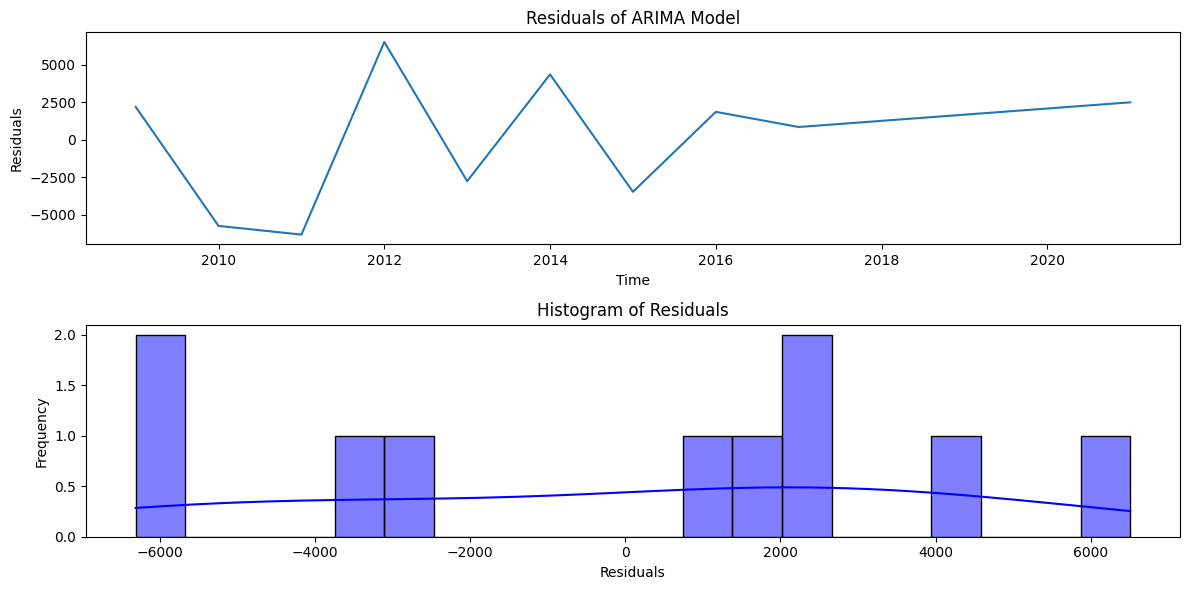

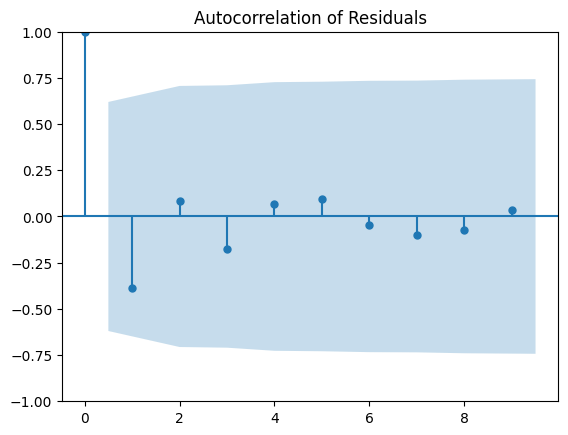

Shapiro-Wilk Test: Statistic=0.9401566423484116, p-value=0.5547576964569141
D'Agostino's K-squared Test: Statistic=1.0057906661968352, p-value=0.6047770912258094


In [66]:
# Extract residuals from the ARIMA model
residuals = median_cost_arima_model.resid()

# Plot residuals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(2, 1, 2)
sns.histplot(residuals, kde=True, bins=20, color='blue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Dynamically set the maximum lags based on the length of residuals
max_lags = min(20, len(residuals) - 1)  # Ensure lags do not exceed the number of residuals

# Plot autocorrelation of residuals
plot_acf(residuals, lags=max_lags)
plt.title('Autocorrelation of Residuals')
plt.show()

# Perform statistical tests
shapiro_test = shapiro(residuals)
dagostino_test = normaltest(residuals)

print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
print(f"D'Agostino's K-squared Test: Statistic={dagostino_test.statistic}, p-value={dagostino_test.pvalue}")

### Interpretation
Our ARIMA model once again passes the residual normality checks!

In [68]:
median_charges_series = aggregated_data.set_index('Year')['Median Charge']
print(median_charges_series)

Year
2009    67627.0000
2010    35562.5000
2011    33057.7650
2012    90278.3750
2013    41394.1250
2014    73108.8775
2015    42767.3750
2016    71421.7500
2017    69016.1250
2021    78872.8975
Name: Median Charge, dtype: float64


In [71]:
# Perform auto_arima on the series
medcharges_arima_model = auto_arima(
    median_charges_series,
    seasonal=False,  # No seasonality in the data
    trace=True,      # Show the progress of model selection
    error_action='ignore',  # Ignore errors during model fitting
    suppress_warnings=True, # Suppress warnings
    stepwise=True     # Use stepwise approach for faster computation
)

# Print the summary of the selected model
print(medcharges_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=251.488, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=241.219, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=250.304, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=237.978, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=238.393, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=237.157, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=232.703, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=237.950, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=230.289, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=229.615, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 

In [74]:
# Retrieve the predicted value for 2022
predicted_2022_median_charges = medcharges_arima_model.predict(n_periods=1)[10]
print(f"Predicted median charges for 2022: {predicted_2022_median_charges}")

Predicted median charges for 2022: 60310.679000000004


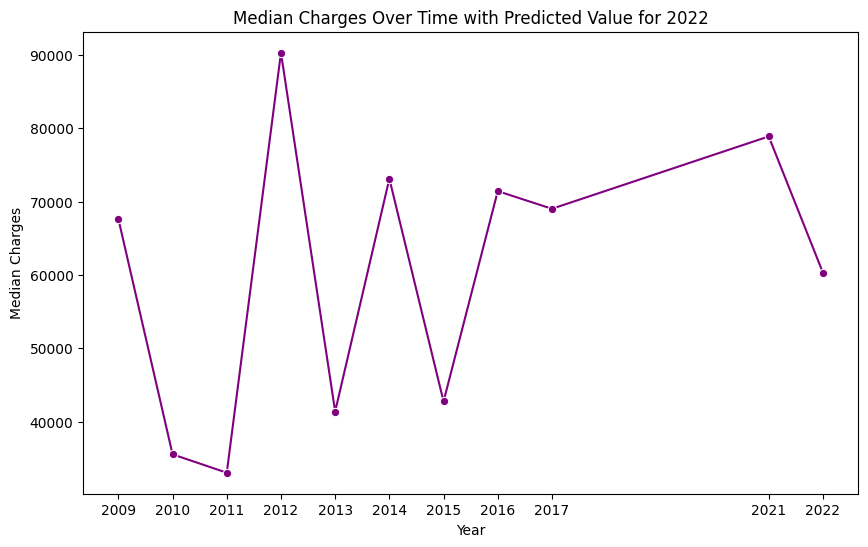

In [75]:
# Extend the median charges series with the 2022 forecast
extended_median_charges_series = pd.concat([median_charges_series, pd.Series({2022: predicted_2022_median_charges})])

# Plot the extended series
plt.figure(figsize=(10, 6))
sns.lineplot(data=extended_median_charges_series, marker='o', color='purple')
plt.title('Median Charges Over Time with Predicted Value for 2022')
plt.xlabel('Year')
plt.ylabel('Median Charges')
plt.xticks(extended_median_charges_series.index)  # Ensure all years are shown on the x-axis
plt.show()

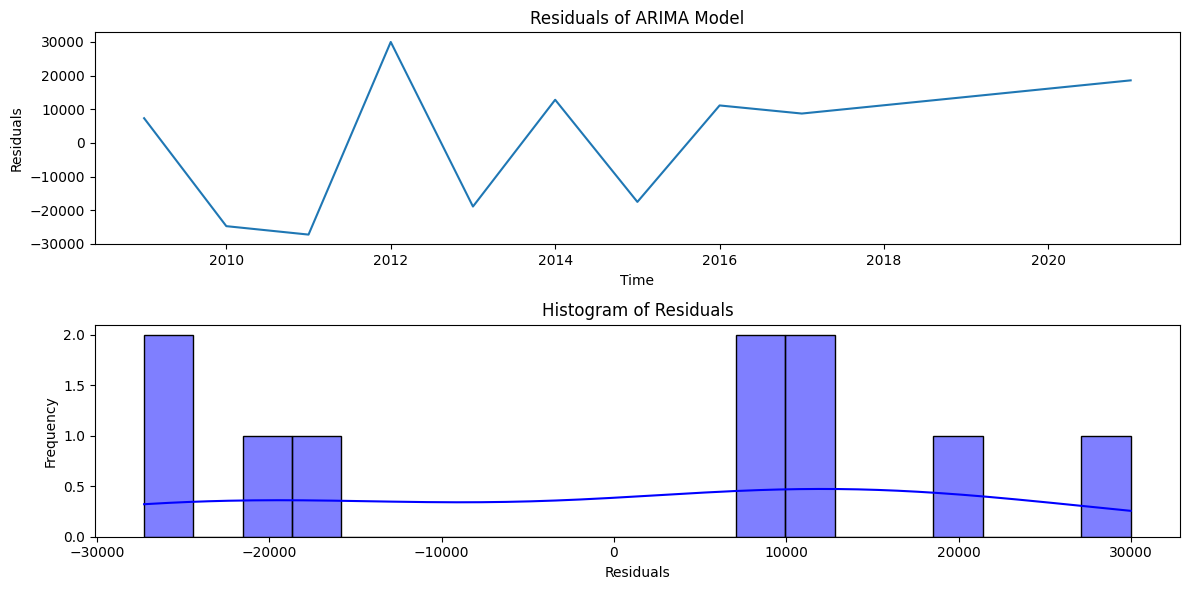

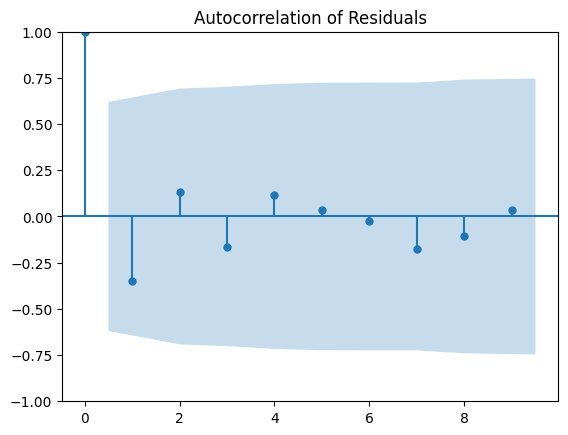

Shapiro-Wilk Test: Statistic=0.8968286891164693, p-value=0.20214296669198417
D'Agostino's K-squared Test: Statistic=2.256624275423657, p-value=0.32357895247393464


In [76]:
# Extract residuals from the ARIMA model
residuals = medcharges_arima_model.resid()

# Plot residuals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(2, 1, 2)
sns.histplot(residuals, kde=True, bins=20, color='blue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Dynamically set the maximum lags based on the length of residuals
max_lags = min(20, len(residuals) - 1)  # Ensure lags do not exceed the number of residuals

# Plot autocorrelation of residuals
plot_acf(residuals, lags=max_lags)
plt.title('Autocorrelation of Residuals')
plt.show()

# Perform statistical tests
shapiro_test = shapiro(residuals)
dagostino_test = normaltest(residuals)

print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
print(f"D'Agostino's K-squared Test: Statistic={dagostino_test.statistic}, p-value={dagostino_test.pvalue}")

### Interpretation
Our ARIMA model once again passes the residual normality checks!

# Conclusion
This analysis provided valuable insights into hospital inpatient discharges and associated costs, focusing on Good Samaritan Hospital Medical Center and APR DRG Code 135. Key findings include:

- **Discharges**: A clear upward trend in discharges was observed, with a predicted value of approximately 120 for 2022.
- **Median Costs**: Median costs showed variability over the years, with a predicted value of around $11,941 for 2022.
- **Median Charges**: Median charges also fluctuated, with a predicted value of approximately $60,311 for 2022.

The ARIMA models used for forecasting demonstrated good performance, with residuals passing normality tests, ensuring reliable predictions. These insights can aid in resource allocation and strategic planning for healthcare facilities. Future work could explore additional factors influencing costs and discharges to enhance predictive accuracy.